In [116]:
import numpy as np
import matplotlib.pyplot as plt

import load_split
import mean_covariance
import Bayes_decisions_Model_evaluation as BDME
import MVG.MVG as MVG

In [117]:
D, L = load_split.load_iris()
(DTR, LTR), (DVAL, LVAL) = load_split.split_db_2to1(D, L)
print("Training data shape: ", DTR.shape)
print("Training labels shape: ", LTR.shape)
print("Evaluation data shape: ", DVAL.shape)
print("Evaluation labels shape: ", LVAL.shape)

Training data shape:  (4, 100)
Training labels shape:  (100,)
Evaluation data shape:  (4, 50)
Evaluation labels shape:  (50,)


In [118]:
#Select for each sample the class with the highest posterior probability
PVAL_MVG, err = MVG.pipeline(DTR, LTR, DVAL, LVAL) #select the class with the highest posterior probability for each sample, set axis=0 to select the class with the highest posterior probability for each sample
print(f"Predictions shape: {PVAL_MVG.shape}")
print(f"Predictions: {PVAL_MVG}")

Predictions shape: (50,)
Predictions: [0 0 1 2 2 0 0 0 1 1 0 0 1 0 2 1 2 1 0 2 0 2 0 0 2 0 2 1 1 1 2 2 2 1 0 1 2
 2 0 1 1 2 1 0 0 0 2 1 2 0]


In [119]:
error_count_MVG = np.count_nonzero(PVAL_MVG != LVAL)
print(f"Number of wrong predictions: {error_count_MVG}")
error_rate_MVG = np.mean(PVAL_MVG != LVAL)
print(f"Error Rate: {error_rate_MVG:.2%}")

Number of wrong predictions: 2
Error Rate: 4.00%


Accuracy, Precision, Recall, F-1 Score for the MVG gmm model: <br>
With 3 classes, accuracy is compute as:
$
acc = \frac{Correct \space predictions}{Tot \space samples} = \frac{T0+T1+T2}{T0+T1+T2+F0+F1+F2} = 1 - Error \space Rate
$

In [120]:
from sklearn.metrics import classification_report #for generating the classification report of the models
print(classification_report(LVAL, PVAL_MVG, digits=3))

              precision    recall  f1-score   support

           0      1.000     1.000     1.000        19
           1      1.000     0.882     0.938        17
           2      0.875     1.000     0.933        14

    accuracy                          0.960        50
   macro avg      0.958     0.961     0.957        50
weighted avg      0.965     0.960     0.960        50



Same for the naive e tied assumption
...


In [121]:
PVAL_MVG_NB, error_rate_NB = MVG.pipeline_Naive(DTR, LTR, DVAL, LVAL)
PVAL_MVG_TiedCov, error_rate_TiedCov = MVG.pipeline_TiedCov(DTR, LTR, DVAL, LVAL)

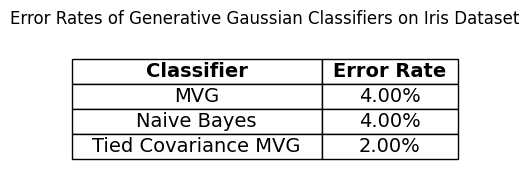

In [122]:
error_rates = [
    ("MVG", error_rate_MVG),
    ("Naive Bayes", error_rate_NB),
    ("Tied Covariance MVG", error_rate_TiedCov)
]

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table_data = [[name, f"{error:.2%}"] for name, error in error_rates]
table = ax.table(cellText=table_data, colLabels=["Classifier", "Error Rate"], loc="center")

#center text in the cells
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold')
    else:
        cell.set_text_props(ha='center', va='center')

table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width([0, 1])
table.scale(1.5, 1.5)  # Adjust the scale for better visibility
plt.title("Error Rates of Generative Gaussian Classifiers on Iris Dataset")
plt.show()


## Transizione da Classificazione Multi-classe a Binaria con Controllo Esplicito

### Dal Maximum A Posteriori alla Threshold Ottimale

Nella sezione precedente abbiamo utilizzato l'approccio **Maximum A Posteriori (MAP)** con `np.argmax()` per la classificazione generale:

```python
# Approccio MAP - Multi-classe
predicted_labels = np.argmax(SPost, axis=0)
```

Ora passiamo a un approccio più controllabile per problemi **binari**, utilizzando una **threshold esplicita** sul log-likelihood ratio.

### Perché la Threshold Esplicita?

L'approccio con threshold ci permette di:

- **🎯 Controllo granulare**: Regolare precisamente il trade-off tra precision e recall
- **⚖️ Gestione prior personalizzati**: Adattarsi a dataset sbilanciati o costi asimmetrici
- **📊 Analisi di sensitività**: Testare facilmente diverse soglie decisionali
- **🔍 Interpretabilità**: Capire esattamente come viene presa la decisione

### Implementazione con Controllo Esplicito

```python
# Calcolo del log-likelihood ratio
llr = log_densities[1] - log_densities[0]  # log p(x|C₁) - log p(x|C₀)

# Threshold ottimale basata sui prior
optimal_threshold = np.log(π_0 / π_1)

# Classificazione con controllo esplicito
PVAL_bin = np.where(llr >= optimal_threshold, 1, 0)
```

### Equivalenza Matematica

Con **prior uniformi** (`π₀ = π₁ = 0.5`), i due approcci sono equivalenti:
- `threshold = np.log(0.5/0.5) = 0`
- `llr ≥ 0` equivale a `p(C₁|x) ≥ p(C₀|x)`

### Vantaggi Pratici

| Aspetto | argmax | Threshold |
|---------|--------|-----------|
| **Controllo prior** | Implicito | Esplicito |
| **Multi-classe** | ✅ Nativo | ❌ Solo binario |
| **Tuning** | Limitato | ✅ Flessibile |
| **Interpretabilità** | Moderata | ✅ Alta |
| **Ottimizzazione metriche** | Difficile | ✅ Semplice |

---

*Questa transizione ci permette di ottimizzare specificamente per il problema binario in questione, sfruttando la maggiore flessibilità e controllo offerta dalla threshold esplicita.*

## Binary tasks: log-likelihood ratios and MVG
We now focus on the same binary task we employed for LDA (see Laboratory 3), which requries classifying only two kinds of flowers, iris versicolor and iris virginica.
So, the first thing to to is to extract just the samples of classes iris-versicolor and iris-virginica from the Dataset.

In [123]:
D, L = load_split.load_iris_binary()
(DTR, LTR), (DVAL, LVAL) = load_split.split_db_2to1(D, L)

print("Training data shape: ", DTR.shape)
print("Training labels shape: ", LTR.shape)
print("Evaluation data shape: ", DVAL.shape)
print("Evaluation labels shape: ", LVAL.shape)

Training data shape:  (4, 66)
Training labels shape:  (66,)
Evaluation data shape:  (4, 34)
Evaluation labels shape:  (34,)


In [124]:
#Compute the MLE estimators for class 1 and class 2
mu_1, C_1, = mean_covariance.compute_mu_C(DTR[:, LTR == 0])
mu_2, C_2, = mean_covariance.compute_mu_C(DTR[:, LTR == 1])
print(f"mu_1:\n{mu_1}\nShape: {mu_1.shape}")
print(f"mu_2:\n{mu_2}\nShape: {mu_2.shape}")
print(f"C_1:\n{C_1}\nShape: {C_1.shape}")
print(f"C_2:\n{C_2}\nShape: {C_2.shape}")

mu_1:
[[6.5875  ]
 [2.95625 ]
 [5.571875]
 [2.053125]]
Shape: (4, 1)
mu_2:
[[5.95882353]
 [2.78529412]
 [4.32647059]
 [1.33823529]]
Shape: (4, 1)
C_1:
[[0.41296875 0.06226562 0.29058594 0.04691406]
 [0.06226562 0.06308594 0.04564453 0.03201172]
 [0.29058594 0.04564453 0.28764648 0.04868164]
 [0.04691406 0.03201172 0.04868164 0.05874023]]
Shape: (4, 4)
C_2:
[[0.30948097 0.10851211 0.21991349 0.07186851]
 [0.10851211 0.10831315 0.09627163 0.04173875]
 [0.21991349 0.09627163 0.25018166 0.0807526 ]
 [0.07186851 0.04173875 0.0807526  0.04000865]]
Shape: (4, 4)


In [125]:
#Then we can compute the log-likelihoods for class 1 and class 2 given the MLE parameters of the MVG distribution
#Beware: we use the VALIDATION data to compute the log-likelihoods, not the training data!
loglikelihood_1 = MVG.logpdf_GAU_ND(DVAL, mu_1, C_1)
loglikelihood_2 = MVG.logpdf_GAU_ND(DVAL, mu_2, C_2)
print(f"loglikelihood_1 Shape: {loglikelihood_1.shape}")
print(f"loglikelihood_2 Shape: {loglikelihood_2.shape}")

loglikelihood_1 Shape: (34,)
loglikelihood_2 Shape: (34,)


In [126]:
#Then we compute the 1-D array of the log-likelihood ratios
#In the log-domain, we just need to subtract the log-likelihoods of the two classes
llr_MVG = loglikelihood_2 - loglikelihood_1
print(f"llr Shape: {llr_MVG.shape}")

llr Shape: (34,)


In [127]:
#Classification rule: assign samples whose llr_MVG >= 0 to class 1 and samples whose llr_MVG < 0 to class 0
PVAL_bin_MVG = np.where(llr_MVG >= 0, 1, 0) #assign samples whose llr_MVG >= 0 to class 2 and samples whose llr_MVG < 0 to class 1
print(f"Predictions shape: {PVAL_bin_MVG.shape}")
print(f"Predictions: {PVAL_bin_MVG}")

Predictions shape: (34,)
Predictions: [1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 1 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1]


In [128]:
# Error Rate for Binary MVG Classifier:
error_count_bin_MVG = np.count_nonzero(PVAL_bin_MVG != LVAL)
print(f"Number of wrong predictions: {error_count_bin_MVG}")
error_rate_bin_MVG = np.mean(PVAL_bin_MVG != LVAL)
print(f"Error Rate: {error_rate_bin_MVG:.2%}")

Number of wrong predictions: 3
Error Rate: 8.82%


Tied

In [129]:
TiedCov_Params_bin = MVG.computeParams_ML_TiedCov(DTR, LTR) #compute the CTied and muVect for the training data usign MLE
CTied_bin = TiedCov_Params_bin[0][1]
print(f"mu_1:\n{TiedCov_Params_bin[0][0]}\nShape: {TiedCov_Params_bin[0][0].shape}")
print(f"mu_2:\n{TiedCov_Params_bin[1][0]}\nShape: {TiedCov_Params_bin[1][0].shape}")
print(f"CTied:\n{CTied_bin}\nShape: {CTied_bin.shape}")


mu_1:
[[6.5875  ]
 [2.95625 ]
 [5.571875]
 [2.053125]]
Shape: (4, 1)
mu_2:
[[5.95882353]
 [2.78529412]
 [4.32647059]
 [1.33823529]]
Shape: (4, 1)
CTied:
[[0.35965686 0.08608957 0.25417892 0.05976939]
 [0.08608957 0.0863848  0.07172516 0.03702262]
 [0.25417892 0.07172516 0.26834642 0.06520304]
 [0.05976939 0.03702262 0.06520304 0.04909063]]
Shape: (4, 4)


In [130]:
#Then we can compute the log-likelihoods for class 1 and class 2 given the MLE parameters of the MVG distribution
#Beware: we use the VALIDATION data to compute the log-likelihoods, not the training data!
loglikelihood_1_TiedCov = MVG.logpdf_GAU_ND(DVAL, TiedCov_Params_bin[0][0], CTied_bin)
loglikelihood_2_TiedCov = MVG.logpdf_GAU_ND(DVAL, TiedCov_Params_bin[1][0], CTied_bin)
print(f"loglikelihood_1 Shape: {loglikelihood_1_TiedCov.shape}")
print(f"loglikelihood_2 Shape: {loglikelihood_2_TiedCov.shape}")

loglikelihood_1 Shape: (34,)
loglikelihood_2 Shape: (34,)


In [131]:
#Then we compute the 1-D array of the log-likelihood ratios
#In the log-domain, we just need to subtract the log-likelihoods of the two classes
llr_TiedCov = loglikelihood_2_TiedCov - loglikelihood_1_TiedCov
print(f"llr Shape: {llr_TiedCov.shape}")

llr Shape: (34,)


In [132]:
#Classification rule: assign samples whose llr_MVG >= 0 to class 1 and samples whose llr_MVG < 0 to class 0
PVAL_bin_TiedCov = np.where(llr_TiedCov >= 0, 1, 0)
print(f"Predictions shape: {PVAL_bin_TiedCov.shape}")
print(f"Predictions: {PVAL_bin_TiedCov}")

Predictions shape: (34,)
Predictions: [1 0 1 0 1 1 1 0 0 0 0 0 0 0 1 1 0 1 1 0 0 1 0 0 0 1 1 1 1 0 0 0 1 1]


In [133]:
error_count_bin_TiedCov = np.count_nonzero(PVAL_bin_TiedCov != LVAL)
print(f"Number of wrong predictions: {error_count_bin_TiedCov}")
error_rate_bin_TiedCov = np.mean(PVAL_bin_TiedCov != LVAL)
print(f"Error Rate: {error_rate_bin_TiedCov:.2%}")

Number of wrong predictions: 2
Error Rate: 5.88%


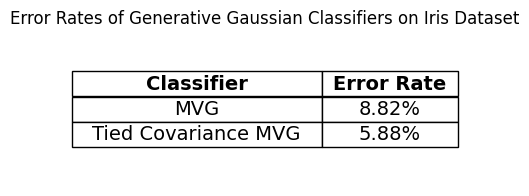

In [134]:
error_rates = [
    ("MVG", error_rate_bin_MVG),
    ("Tied Covariance MVG", error_rate_bin_TiedCov)
]

fig, ax = plt.subplots(figsize=(5, 2))
ax.axis('tight')
ax.axis('off')

table_data = [[name, f"{error:.2%}"] for name, error in error_rates]
table = ax.table(cellText=table_data, colLabels=["Classifier", "Error Rate"], loc="center")

#center text in the cells
for (i, j), cell in table.get_celld().items():
    if i == 0:
        cell.set_text_props(weight='bold')
    else:
        cell.set_text_props(ha='center', va='center')

table.auto_set_font_size(False)
table.set_fontsize(14)
table.auto_set_column_width([0, 1])
table.scale(1.5, 1.5)  # Adjust the scale for better visibility
plt.title("Error Rates of Generative Gaussian Classifiers on Iris Dataset")
plt.show()
